# 데이터 로드

In [1]:
!pip install konlpy --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 19.4 MB 1.2 MB/s 
     |████████████████████████████████| 465 kB 68.4 MB/s 


In [28]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import urllib.request
from konlpy.tag import Okt
from tqdm import tqdm
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [3]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt", filename="ratings_train.txt")
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt", filename="ratings_test.txt")

('ratings_test.txt', <http.client.HTTPMessage at 0x7f9ca6acb4f0>)

In [4]:
train = pd.read_csv("ratings_train.txt", sep='\t')
test = pd.read_csv("ratings_test.txt", sep='\t')

In [5]:
print(train.shape)
train.head()

(150000, 3)


,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [6]:
print(test.shape)
test.head()

(50000, 3)


,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0


# 데이터 전처리

## 데이터 전처리를 위한 데이터 병합

In [7]:
raw = pd.concat([train, test])
print(raw.shape)
raw.head()

(200000, 3)


,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


## 중복데이터 제거

In [8]:
raw.shape[0], raw['document'].nunique()

(200000, 194543)

* 중복 데이터가 존재

In [9]:
raw.drop_duplicates(subset=['document'], inplace=True)

In [10]:
raw.shape[0]

194544

## label 값 

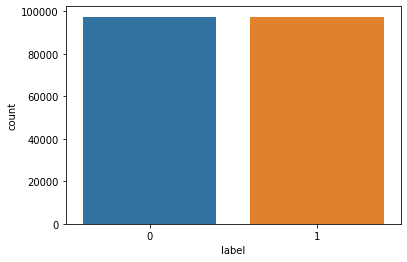

In [11]:
sns.countplot(data=raw, x='label')

In [12]:
raw.groupby('label').size().reset_index(name='count')

,label,count
0,0,97375
1,1,97169


## 결측치 처리

In [13]:
raw.isnull().sum()

id          0
document    1
label       0
dtype: int64

In [14]:
raw.loc[raw.document.isnull()]

,id,document,label
25857,2172111,NaN,1


In [15]:
raw = raw.dropna()

In [16]:
raw.shape

(194543, 3)

## 문자 전처리

In [17]:
raw['document'] = raw['document'].map(lambda x: re.sub("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]", "", x))
raw.head()

,id,document,label
0,9976970,아 더빙 진짜 짜증나네요 목소리,0
1,3819312,흠포스터보고 초딩영화줄오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 솔직히 재미는 없다평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화스파이더맨에서 늙어보이기만 했던 커스틴 던...,1


## 한글로 변경 후 공백 데이터 값 처리

In [18]:
raw['document'].map(lambda x : re.sub('^ +', " ", x))
raw['document'].replace('', np.nan, inplace=True)
raw.isnull().sum()

id            0
document    491
label         0
dtype: int64

In [19]:
raw.loc[raw.document.isnull()]

,id,document,label
584,7117896,NaN,0
593,6478189,NaN,0
638,9364602,NaN,0
668,1600635,NaN,0
1559,6918082,NaN,1
...,...,...,...
48862,9665591,NaN,0
49094,10251648,NaN,1
49803,5309713,NaN,1
49871,9767991,NaN,0


In [20]:
raw = raw.dropna()

In [21]:
raw.isnull().sum()

id          0
document    0
label       0
dtype: int64

## 불용어 처리

In [114]:
stops = ['의','가','이','은','들','는','좀',
             '잘','걍','과','도','를','으로','자','에','와','한','하다']

In [22]:
def remove_stopword(text):
    token = text.split(" ")
    stops = ['의','가','이','은','들','는','좀',
             '잘','걍','과','도','를','으로','자','에','와','한','하다']
    meaningful_words = [w for w in token if not w in stops]
    return ' '.join(meaningful_words)

In [23]:
raw['document'].map(lambda x: remove_stopword(x))
raw['document'].head()

0                                    아 더빙 진짜 짜증나네요 목소리
1                           흠포스터보고 초딩영화줄오버연기조차 가볍지 않구나
2                                    너무재밓었다그래서보는것을추천한다
3                            교도소 이야기구먼 솔직히 재미는 없다평점 조정
4    사이몬페그의 익살스런 연기가 돋보였던 영화스파이더맨에서 늙어보이기만 했던 커스틴 던...
Name: document, dtype: object

In [29]:
X = []
for sentence in tqdm(raw['document']):
    okt = Okt()
    tokenized_sentence = okt.morphs(sentence, stem=True)
    X.append(tokenized_sentence)

100%|██████████| 194052/194052 [14:13<00:00, 227.24it/s]


# 인코딩

In [31]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)

In [32]:
print(tokenizer.word_index)

{'이': 1, '영화': 2, '보다': 3, '하다': 4, '의': 5, '에': 6, '가': 7, '을': 8, '도': 9, '들': 10, '는': 11, '를': 12, '은': 13, '없다': 14, '이다': 15, '있다': 16, '좋다': 17, '너무': 18, '다': 19, '정말': 20, '한': 21, '되다': 22, '재밌다': 23, '적': 24, '만': 25, '진짜': 26, '같다': 27, '으로': 28, '로': 29, '아니다': 30, '않다': 31, '점': 32, '에서': 33, '만들다': 34, '나오다': 35, '과': 36, '연기': 37, '평점': 38, '것': 39, '내': 40, '최고': 41, '그': 42, '나': 43, '인': 44, '안': 45, '생각': 46, '못': 47, '스토리': 48, '왜': 49, '드라마': 50, '게': 51, '사람': 52, '감동': 53, '보고': 54, '이렇다': 55, '고': 56, '말': 57, '더': 58, '아깝다': 59, '때': 60, '배우': 61, '와': 62, 'ㅋㅋ': 63, '감독': 64, '아': 65, '거': 66, '그냥': 67, '재미있다': 68, '요': 69, '재미': 70, '내용': 71, '시간': 72, '까지': 73, '중': 74, '주다': 75, '뭐': 76, '자다': 77, '좀': 78, '하고': 79, '지루하다': 80, '재미없다': 81, '수': 82, '네': 83, '쓰레기': 84, '가다': 85, '들다': 86, '모르다': 87, '그렇다': 88, '싶다': 89, '지': 90, '사랑': 91, '작품': 92, '알다': 93, '다시': 94, '하나': 95, '볼': 96, '마지막': 97, '잘': 98, '이건': 99, '저': 100, '정도': 101, '오다': 102, 'ㅠㅠ': 103,

In [37]:
threshold = 3
total_cnt = len(tokenizer.word_index)
rare_cnt = 0
total_freq = 0
rare_freq = 0

# 단어와 빈도수 key, value
for key, value in tokenizer.word_counts.items():
    total_freq += value

    if(value < threshold):
        rare_cnt += 1
        rare_freq += value

print("vobab의 크기 : ", total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("희귀 단어 비율 : ", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀단어 등장 빈도 비율: ", (rare_freq / total_freq)*100)

vobab의 크기 :  49663
등장 빈도가 2번 이하인 희귀 단어의 수: 27461
희귀 단어 비율 :  55.29468618488613
전체 등장 빈도에서 희귀단어 등장 빈도 비율:  1.3235062707517034


* 등장 빈도 2이하 단어 제외


In [38]:
vocab_size = total_cnt - rare_cnt + 1
print('단어 집합의 크기 :', vocab_size)

단어 집합의 크기 : 22203


In [56]:
X = raw['document']

In [57]:
y = raw['label']

# 문제&정답값 처리

In [58]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                    stratify=y, random_state=42)

In [59]:
tokenizer = Tokenizer(vocab_size)
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [62]:
y_train.shape, y_test.shape

((155241,), (38811,))

# 빈 샘플 제거


In [63]:
drop_train = [index for index, senetence in enumerate(X_train) if len(sentence) < 1]

In [64]:
X_train = np.delete(X_train, drop_train, axis=0)
y_train = np.delete(y_train, drop_train, axis=0)

print(len(X_train))
print(len(y_train))

155241
155241


/usr/local/lib/python3.8/dist-packages/numpy/lib/function_base.py:4454: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asarray(arr)


# Padding 패딩

In [69]:
!pip install koreanize-matplotlib
import koreanize_matplotlib
%config InlineBackend.figure_format = 'retina'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.5 MB 15.0 MB/s 


리뷰 최대 길이 :  38
리뷰 평균 길이 :  5.281968036794404


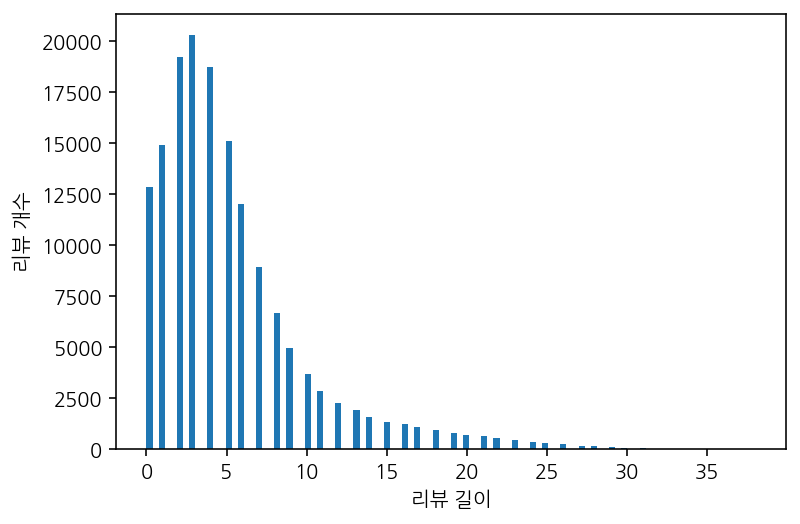

In [70]:
print("리뷰 최대 길이 : ", max(len(review) for review in X_train))
print("리뷰 평균 길이 : ", sum(map(len, X_train))/len(X_train))
plt.hist([len(review) for review in X_train], bins=100);
plt.xlabel('리뷰 길이')
plt.ylabel('리뷰 개수')
plt.show()

In [71]:
def below_threshold_len(max_len, nested_list):
    count = 0
    for sentence in nested_list:
        if(len(sentence) <= max_len):
            count += 1
    print('전체 샘플 중 길이가 %s 이하인 샘플의 비율 : %s'%(max_len, (count / len(nested_list))*100))

In [74]:
max_len = 13
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 13 이하인 샘플의 비율 : 93.0289034468987


* 전체 훈련 데이터 중 대략 93%의 리뷰가 13이하의 길이를 가진다. 
* 모든 샘플의 길이를 13으로 맞춘다.

In [75]:
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

# GRU


In [76]:
from tensorflow.keras.layers import Dense, Embedding, GRU, Bidirectional, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model

In [83]:
embedding_dim = 100

model = Sequential()

# 입력-임베딩 층
model.add(Embedding(input_dim=vocab_size, 
                    output_dim=embedding_dim, 
                    input_length=max_len))
model.add(Bidirectional(GRU(units=128, return_sequences=True)))
model.add(Bidirectional(GRU(units=128)))
model.add(Dense(units=64))
# 출력층
model.add(Dense(units=1, activation='sigmoid'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 13, 100)           2220300   
                                                                 
 bidirectional_4 (Bidirectio  (None, 13, 256)          176640    
 nal)                                                            
                                                                 
 bidirectional_5 (Bidirectio  (None, 256)              296448    
 nal)                                                            
                                                                 
 dense_3 (Dense)             (None, 64)                16448     
                                                                 
 dense_4 (Dense)             (None, 1)                 65        
                                                                 
Total params: 2,709,901
Trainable params: 2,709,901
No

In [84]:
model.compile(optimizer='adam',
            loss='binary_crossentropy',
            metrics=['accuracy'])

In [85]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=5)

In [86]:
history = model.fit(X_train, y_train, validation_split=0.2, 
			epochs=10, callbacks=[early_stop])

Epoch 1/10
3881/3881 [==============================] - 58s 13ms/step - loss: 0.4481 - accuracy: 0.7734 - val_loss: 0.4130 - val_accuracy: 0.7948
Epoch 2/10
3881/3881 [==============================] - 48s 12ms/step - loss: 0.3414 - accuracy: 0.8335 - val_loss: 0.4239 - val_accuracy: 0.7963
Epoch 3/10
3881/3881 [==============================] - 46s 12ms/step - loss: 0.2769 - accuracy: 0.8647 - val_loss: 0.4440 - val_accuracy: 0.7893
Epoch 4/10
3881/3881 [==============================] - 45s 12ms/step - loss: 0.2235 - accuracy: 0.8881 - val_loss: 0.5286 - val_accuracy: 0.7841
Epoch 5/10
3881/3881 [==============================] - 45s 12ms/step - loss: 0.1822 - accuracy: 0.9062 - val_loss: 0.6342 - val_accuracy: 0.7749
Epoch 6/10
3881/3881 [==============================] - 45s 12ms/step - loss: 0.1550 - accuracy: 0.9166 - val_loss: 0.7462 - val_accuracy: 0.7717


In [89]:
df_hist = pd.DataFrame(history.history)
df_hist

,loss,accuracy,val_loss,val_accuracy
0,0.448114,0.773391,0.412973,0.794840
1,0.341357,0.833516,0.423855,0.796290
2,0.276902,0.864750,0.444028,0.789333
3,0.223487,0.888117,0.528588,0.784148
4,0.182243,0.906234,0.634250,0.774936
5,0.154996,0.916637,0.746205,0.771683


# LSTM

In [90]:
from tensorflow.keras.layers import LSTM

In [100]:
model = Sequential()
# 입력-임베딩 층
model.add(Embedding(input_dim=vocab_size, 
                    output_dim=embedding_dim, 
                    input_length=max_len))
model.add(Bidirectional(LSTM(units=128, return_sequences=True)))
model.add(Bidirectional(LSTM(units=128, return_sequences=True)))
model.add(Bidirectional(LSTM(units=64)))
model.add(Dense(units=16))
# 출력층
model.add(Dense(units=1, activation='sigmoid'))
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 13, 100)           2220300   
                                                                 
 bidirectional_9 (Bidirectio  (None, 13, 256)          234496    
 nal)                                                            
                                                                 
 bidirectional_10 (Bidirecti  (None, 13, 256)          394240    
 onal)                                                           
                                                                 
 bidirectional_11 (Bidirecti  (None, 128)              164352    
 onal)                                                           
                                                                 
 dense_7 (Dense)             (None, 16)                2064      
                                                      

In [106]:
from tensorflow.keras.callbacks import ModelCheckpoint
early_stop = EarlyStopping(monitor='val_loss', mode='min', patience=5)
mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

In [107]:
model.compile(optimizer='rmsprop',
            loss='binary_crossentropy',
            metrics=['accuracy'])

In [108]:
history = model.fit(X_train, y_train, validation_split=0.2, 
			epochs=10, callbacks=[early_stop, mc])

Epoch 1/10
3879/3881 [============================>.] - ETA: 0s - loss: 0.1465 - accuracy: 0.9239
Epoch 1: val_accuracy improved from -inf to 0.77387, saving model to best_model.h5
3881/3881 [==============================] - 87s 21ms/step - loss: 0.1465 - accuracy: 0.9239 - val_loss: 0.6726 - val_accuracy: 0.7739
Epoch 2/10
3880/3881 [============================>.] - ETA: 0s - loss: 0.1605 - accuracy: 0.9211
Epoch 2: val_accuracy improved from 0.77387 to 0.77861, saving model to best_model.h5
3881/3881 [==============================] - 78s 20ms/step - loss: 0.1605 - accuracy: 0.9211 - val_loss: 0.7139 - val_accuracy: 0.7786
Epoch 3/10
3879/3881 [============================>.] - ETA: 0s - loss: 0.1683 - accuracy: 0.9195
Epoch 3: val_accuracy did not improve from 0.77861
3881/3881 [==============================] - 77s 20ms/step - loss: 0.1683 - accuracy: 0.9195 - val_loss: 0.6191 - val_accuracy: 0.7693
Epoch 4/10
3879/3881 [============================>.] - ETA: 0s - loss: 0.1694 - 

In [94]:
df_LSTM_hist = pd.DataFrame(history.history)
df_LSTM_hist

,loss,accuracy,val_loss,val_accuracy
0,0.450044,0.771539,0.412371,0.791169
1,0.344367,0.831213,0.417929,0.792715
2,0.285429,0.858670,0.447513,0.792715
3,0.235634,0.881941,0.516899,0.787368
4,0.194356,0.900710,0.648941,0.776611
5,0.165226,0.913038,0.718449,0.779864


In [109]:
loaded_model = load_model('best_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

1213/1213 [==============================] - 13s 8ms/step - loss: 0.7061 - accuracy: 0.7784

 테스트 정확도: 0.7784


# 리뷰 예측

In [112]:
def sentiment_predict(new_sentence):
  new_sentence = re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣 ]','', new_sentence)
  new_sentence = okt.morphs(new_sentence, stem=True) # 토큰화
  new_sentence = [word for word in new_sentence if not word in stops] # 불용어 제거
  encoded = tokenizer.texts_to_sequences([new_sentence]) # 정수 인코딩
  pad_new = pad_sequences(encoded, maxlen = max_len) # 패딩
  score = float(loaded_model.predict(pad_new)) # 예측
  if(score > 0.5):
    print("{:.2f}% 확률로 긍정 리뷰입니다.\n".format(score * 100))
  else:
    print("{:.2f}% 확률로 부정 리뷰입니다.\n".format((1 - score) * 100))

In [115]:
sentiment_predict("이 영화 재밌다 ㅋㅋㅋㅋㅋ")

1/1 [==============================] - 4s 4s/step
99.21% 확률로 긍정 리뷰입니다.



In [116]:
sentiment_predict("이 영화 뭐야.. 너무 돈 아까움")

1/1 [==============================] - 0s 38ms/step
99.63% 확률로 부정 리뷰입니다.



In [117]:
sentiment_predict("우와 다음에 또 봐야지")

1/1 [==============================] - 0s 23ms/step
65.44% 확률로 긍정 리뷰입니다.



In [118]:
sentiment_predict("시간 아까워.. 잠이나 잘 걸")

1/1 [==============================] - 0s 39ms/step
99.63% 확률로 부정 리뷰입니다.

